Using device: cpu
Starting L-BFGS optimization...
--- Epoch 1/1 ---
Iter: 50, Loss: 8.3728e-02 (PDE: 2.86e-03, IC: 1.37e-02, Psi: 6.71e-02)
Iter: 100, Loss: 3.1348e-02 (PDE: 7.96e-05, IC: 5.13e-03, Psi: 2.61e-02)
Iter: 150, Loss: 1.4413e-02 (PDE: 1.75e-04, IC: 7.89e-03, Psi: 6.35e-03)
Iter: 200, Loss: 1.1825e-02 (PDE: 2.07e-05, IC: 6.53e-03, Psi: 5.27e-03)
Iter: 250, Loss: 8.7207e-03 (PDE: 6.30e-05, IC: 4.04e-03, Psi: 4.61e-03)
Iter: 300, Loss: 7.5125e-03 (PDE: 1.50e-04, IC: 3.80e-03, Psi: 3.56e-03)
Iter: 350, Loss: 7.1905e-03 (PDE: 8.53e-05, IC: 3.43e-03, Psi: 3.67e-03)
Iter: 400, Loss: 7.0884e-03 (PDE: 6.89e-05, IC: 3.54e-03, Psi: 3.48e-03)
Iter: 450, Loss: 6.9631e-03 (PDE: 9.42e-05, IC: 3.46e-03, Psi: 3.41e-03)
Iter: 500, Loss: 6.9044e-03 (PDE: 8.12e-05, IC: 3.41e-03, Psi: 3.41e-03)
Iter: 550, Loss: 3.9642e-02 (PDE: 3.28e-02, IC: 3.35e-03, Psi: 3.44e-03)
Iter: 600, Loss: 6.8657e-03 (PDE: 9.21e-05, IC: 3.32e-03, Psi: 3.45e-03)
--- Epoch 1 completed in 14.98s ---
Epoch 1 Final Check -

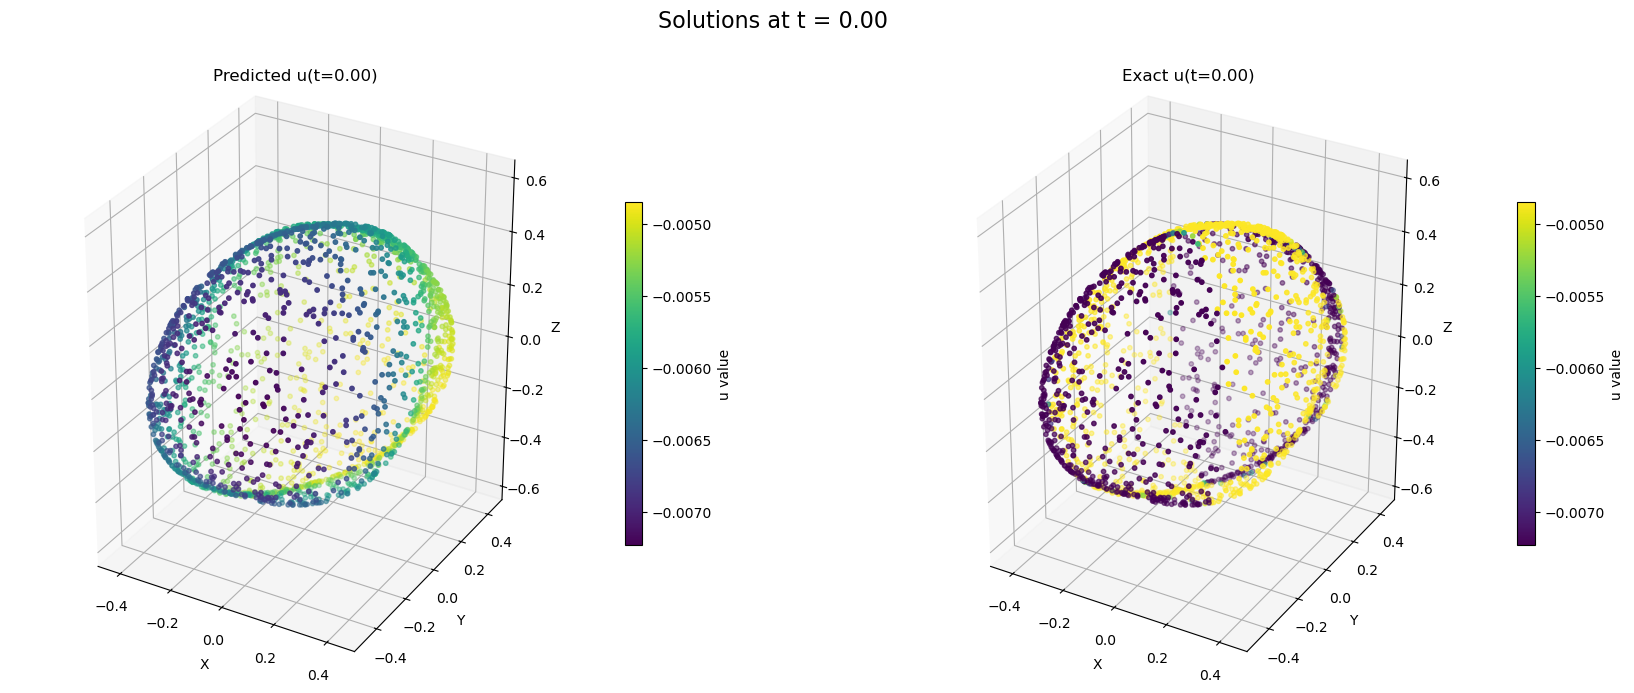

  Plotting for t = 0.20


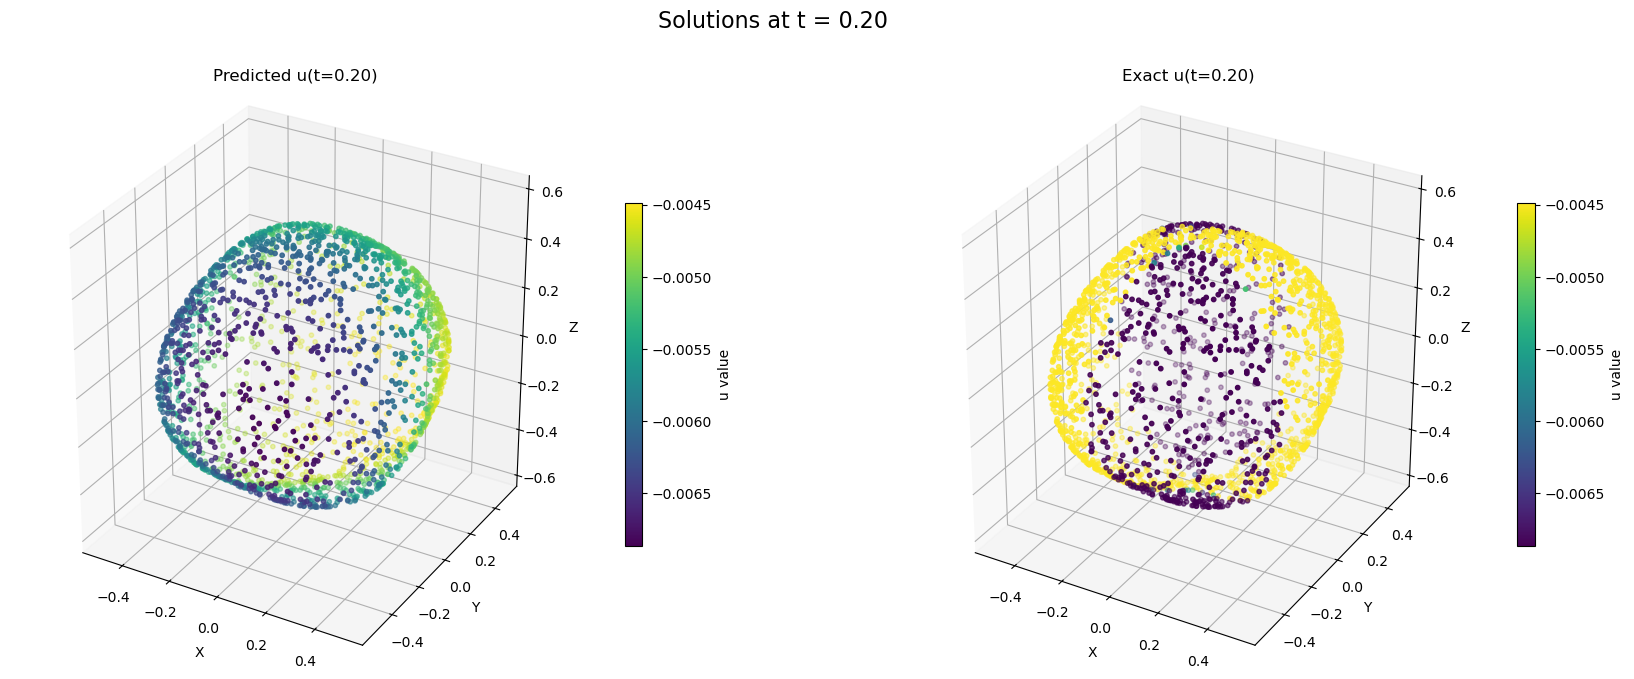

  Plotting for t = 0.40


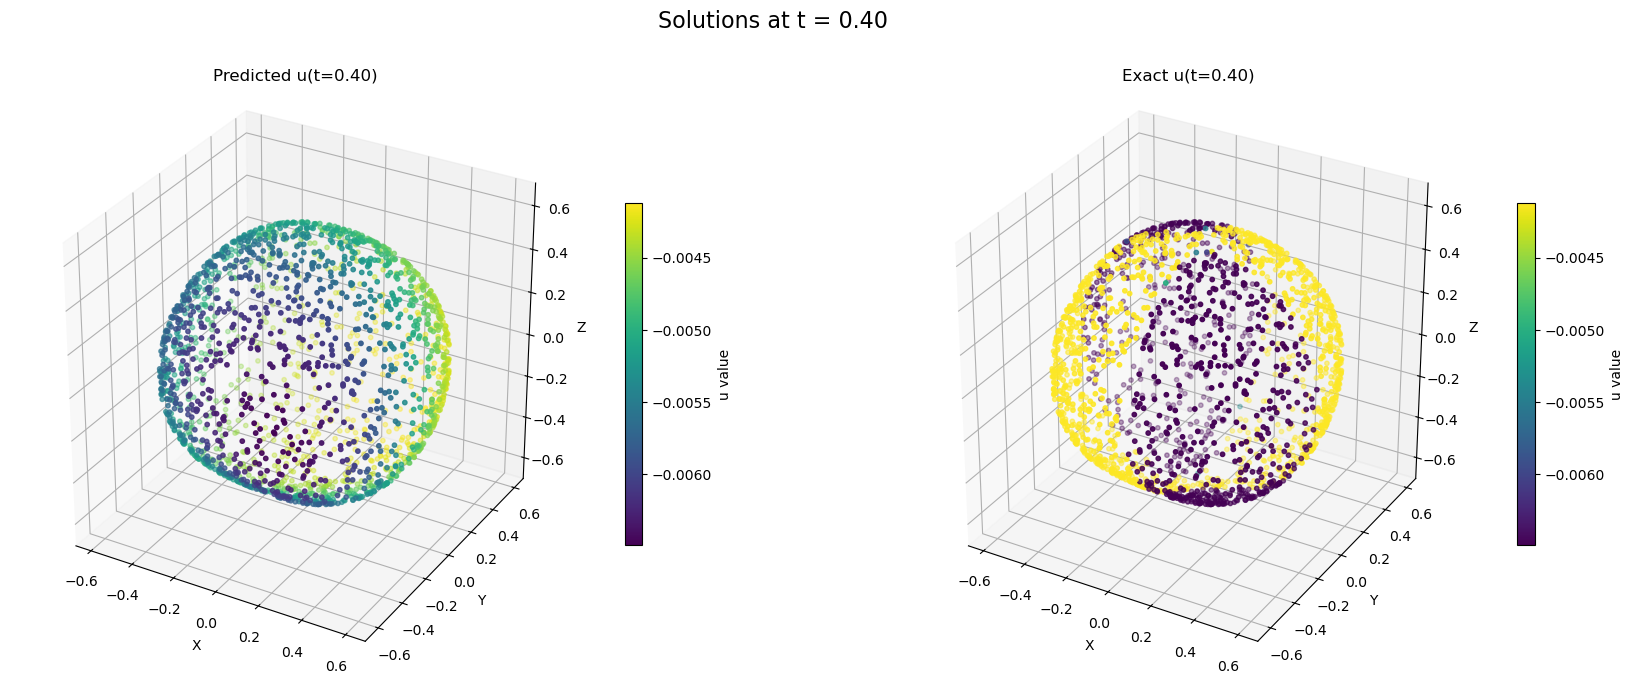

  Plotting for t = 0.60


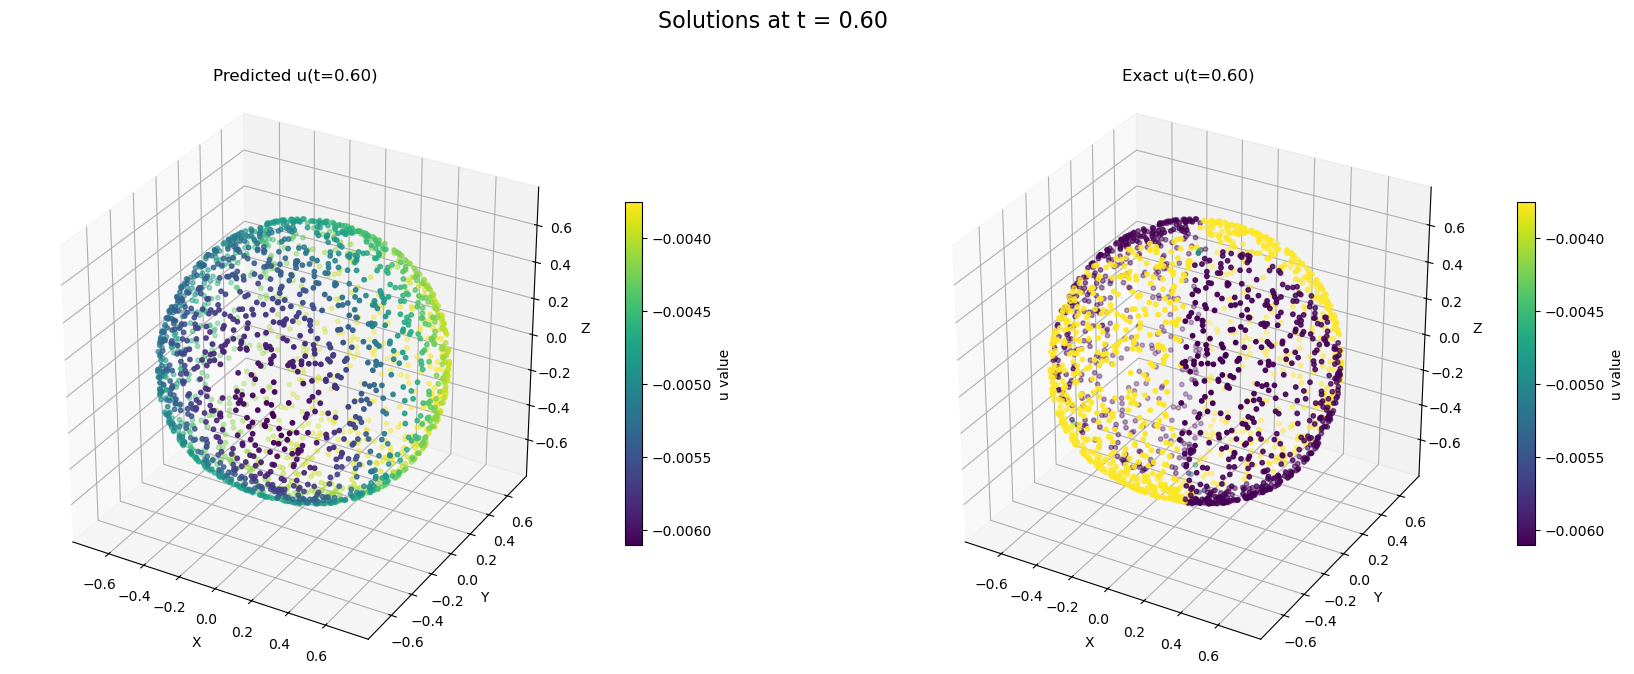

  Plotting for t = 0.80


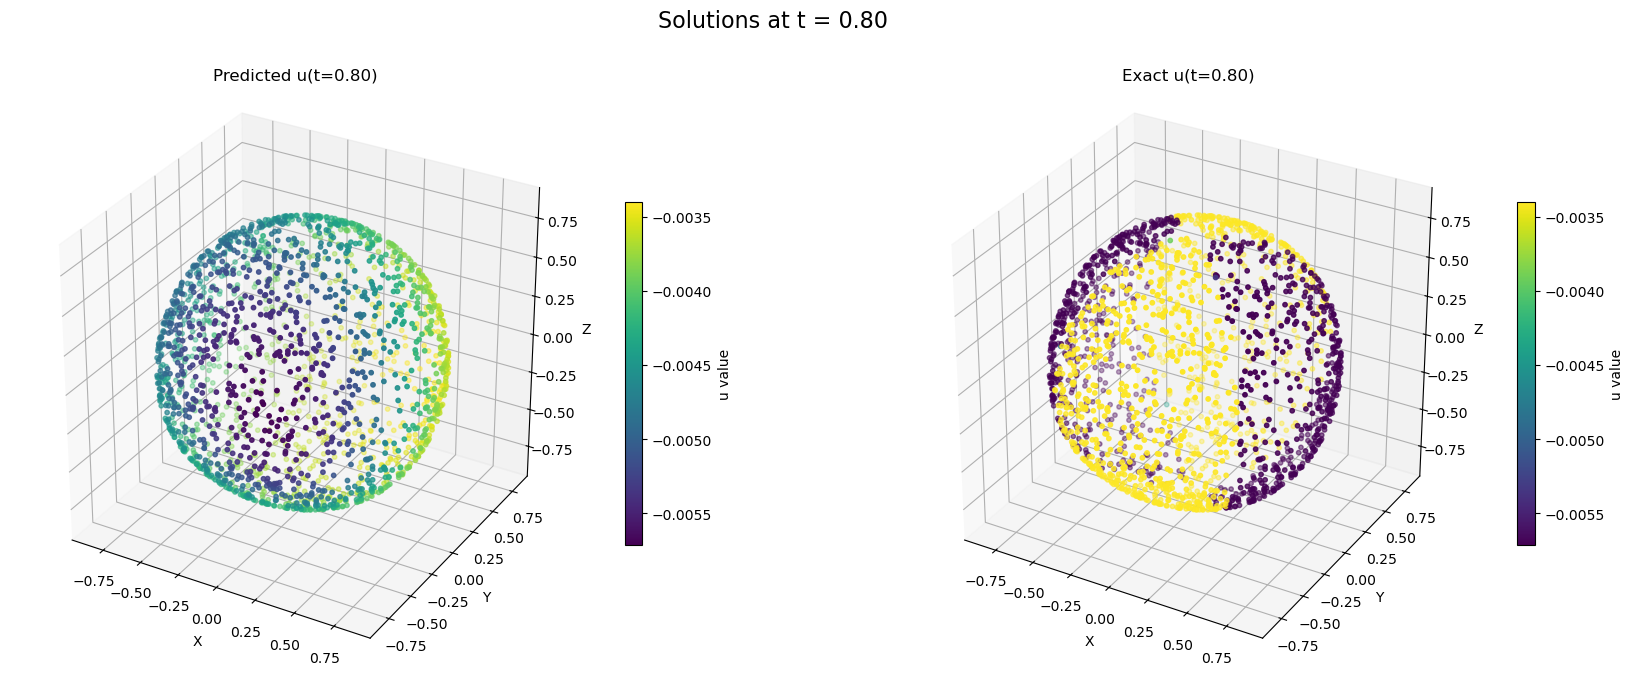

  Plotting for t = 1.00


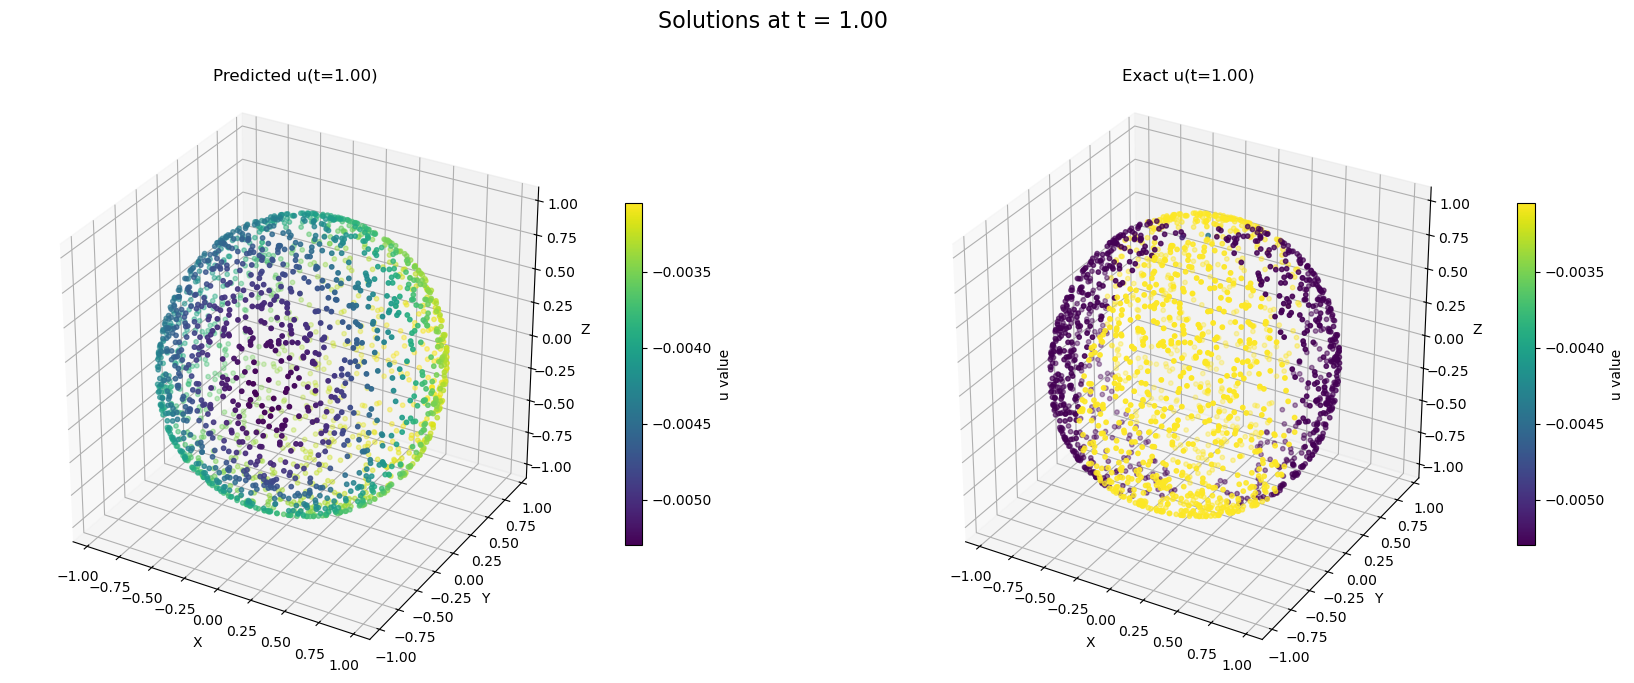

Visualizations finished.


In [51]:
# --- Needed Libraries ---
import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math # For pi

# --- Configuration ---
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.set_default_dtype(torch.float64) # Use double precision as in paper/notebook

# --- Problem Setup (Section 4.3) ---
# Evolving sphere: sqrt(x^2+y^2+z^2) - R(t) = 0
def R_func(t):
  """Radius of the sphere at time t."""
  # R(t) = 0.5 * (1 + t^2) # As per paper text [cite: 248]
  # NOTE: Figure 10 caption says R(t) = 1 + 0.5*t^2. Using text version.
  return 0.5 * (1 + t**2)

def psi_sphere(x, y, z, t):
  """Level set function for the evolving sphere."""
  # psi(x, y, z, t) = sqrt(x^2 + y^2 + z^2) - R(t) [cite: 248]
  norm_x = torch.sqrt(x**2 + y**2 + z**2)
  return norm_x - R_func(t)

def grad_psi_sphere(x, y, z, t):
  """Gradient of the level set function w.r.t. (x, y, z)."""
  # Requires gradients for x, y, z
  norm_x = torch.sqrt(x**2 + y**2 + z**2) + 1e-9 # Epsilon for stability
  grad_x = x / norm_x
  grad_y = y / norm_x
  grad_z = z / norm_x
  return torch.stack([grad_x, grad_y, grad_z], dim=-1) # Shape [M, 3]

def grad_psi_t_sphere(x, y, z, t):
   """Time derivative of the level set function."""
   # d(psi)/dt = - dR/dt = - 0.5 * 2*t = -t [cite: 248]
   return -t

# Velocity field on the surface v = (-2y, 2x, 0) [cite: 247]
def velocity_field(x, y, z):
   vx = -2 * y
   vy = 2 * x
   vz = torch.zeros_like(z)
   return torch.stack([vx, vy, vz], dim=-1) # Shape [M, 3]

# Initial condition u(x, y, z, 0) = x^2 - y^2 [cite: 250]
def u_initial(x, y, z):
   return x**2 - y**2

# Analytical solution u(x, y, z, t) = (x*cos(2t)+y*sin(2t))^2 - (-x*sin(2t)+y*cos(2t))^2 [cite: 251]
def u_exact(x, y, z, t):
    xt = x * torch.cos(2 * t) + y * torch.sin(2 * t)
    yt = -x * torch.sin(2 * t) + y * torch.cos(2 * t)
    return xt**2 - yt**2

# PDE: ut + v . grad_s(u) - delta_s(u) = 0 [cite: 246] (epsilon=1, f=0)

# --- Sampling ---
def sample_unit_sphere(num_points):
    """Sample points uniformly on the surface of a unit sphere."""
    vec = torch.randn(num_points, 3, device=device, dtype=torch.float64)
    vec /= torch.linalg.norm(vec, dim=1, keepdim=True)
    return vec # Shape [num_points, 3]

# --- Network Architecture (Section 4.1) ---
class ShallowPINN_Evolving(nn.Module):
    def __init__(self, num_neurons_u, num_neurons_phi):
        super().__init__()
        # Network for solution u(xi, eta, zeta, t) [cite: 216]
        self.net_u = nn.Sequential(
            nn.Linear(4, num_neurons_u), # Input: xi, eta, zeta, t
            nn.Sigmoid(),
            nn.Linear(num_neurons_u, 1, bias=False) # Output: u
        )

        # Network for mapping Phi(xi, eta, zeta, t) [cite: 217]
        # Phi = Id + NN_Phi
        self.net_phi = nn.Sequential(
            nn.Linear(4, num_neurons_phi), # Input: xi, eta, zeta, t
            nn.Sigmoid(),
            nn.Linear(num_neurons_phi, 3, bias=False) # Output: displacement part
        )

        # Initialize weights
        for net in [self.net_u, self.net_phi]:
            for m in net.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        nn.init.zeros_(m.bias)

    def forward(self, xi, eta, zeta, t):
        # Input shape: [M,] for each coordinate/time
        inputs = torch.stack([xi, eta, zeta, t], dim=-1) # Shape [M, 4]

        # Compute solution u
        u_pred = self.net_u(inputs).squeeze(-1) # Shape [M,]

        # Compute mapping Phi = Id + NN_Phi
        identity_map = torch.stack([xi, eta, zeta], dim=-1) # Shape [M, 3]
        displacement = self.net_phi(inputs) # Shape [M, 3]
        phi_pred = identity_map + displacement # Shape [M, 3]

        return u_pred, phi_pred

# --- Differential Operators on Evolving Surface (Section 4.1.1) ---
# Need functions to compute d_t u, grad_s u, delta_s u using the learned map Phi

# This requires computing derivatives of u and Phi w.r.t reference coordinates (xi, eta, zeta) and time t.
# Let x_ref = [xi, eta, zeta]. Let Phi(x_ref, t) = [x(x_ref, t), y(x_ref, t), z(x_ref, t)]
# Let J = nabla_{x_ref} Phi (Jacobian matrix, 3x3)
# Let G = J^T J (Metric tensor, 3x3)
# Let g = det(G)
# Let G^{-1} = (G^{ij}) (Inverse metric tensor, 3x3)

# grad_s u = G^{-1} J^T nabla_{x_ref} u   (Result is a vector in R^3) [cite: 220]
# delta_s u = (1/sqrt(g)) * div_{x_ref} ( sqrt(g) * G^{-1} * nabla_{x_ref} u ) [cite: 221]
# d/dt u(Phi(x_ref, t), t) = partial_t u + Phi_t . grad u  [cite: 222]
# where Phi_t = partial_t Phi and grad u is the R^3 gradient of the embedded u

# The paper uses a different formulation for the material derivative:
# d/dt u(Phi(x_ref, t), t) = partial_t u(x_ref, t) + (Phi_t - v) . grad_s u(x_ref, t)
# where u is the network u(x_ref, t) and grad_s u is the surface gradient also computed w.r.t x_ref.
# Let's follow the paper's formulation.

def compute_operators_evolving(u_net_out, phi_net_out, x_ref_t_with_grad, v_on_surface):
    """
    Computes derivatives needed for the PDE loss on the evolving surface.
    Args:
        u_net_out (Tensor): Output of u network [M,], requires_grad=True.
        phi_net_out (Tensor): Output of Phi network [M, 3], requires_grad=True.
        x_ref_t_with_grad (Tensor): Input tensor [xi, eta, zeta, t] [M, 4], requires_grad=True.
        v_on_surface (Tensor): Velocity field evaluated at Phi(x_ref, t) [M, 3].
    Returns:
        material_deriv (Tensor): d/dt u term [M,]
        laplace_beltrami (Tensor): delta_s u term [M,]
    """
    M = x_ref_t_with_grad.shape[0]
    xi_eta_zeta = x_ref_t_with_grad[:, :3] # Shape [M, 3]
    t_coord = x_ref_t_with_grad[:, 3:4]   # Shape [M, 1]

    # --- 1. Compute Gradients and Jacobians w.r.t reference coords (xi, eta, zeta) ---
    # Gradient of u w.r.t x_ref
    grad_u_x_ref = torch.autograd.grad(u_net_out.sum(), x_ref_t_with_grad, create_graph=True, retain_graph=True)[0][:, :3] # Shape [M, 3]

    # Jacobian of Phi w.r.t x_ref (J = nabla_{x_ref} Phi)
    J = torch.zeros(M, 3, 3, device=device, dtype=torch.float64)
    for i in range(3): # Compute column-wise
        grad_phi_i = torch.autograd.grad(phi_net_out[:, i].sum(), x_ref_t_with_grad, create_graph=True, retain_graph=True)[0][:, :3] # Shape [M, 3]
        J[:, :, i] = grad_phi_i

    # --- 2. Compute Metric Tensor G = J^T J and its determinant/inverse ---
    G = torch.einsum('mij,mik->mjk', J, J) # Shape [M, 3, 3]
    sqrt_g = torch.sqrt(torch.det(G)) + 1e-9 # Shape [M,]
    # Inverse metric G_inv. Use torch.linalg.inv for batch inversion.
    G_inv = torch.linalg.inv(G) # Shape [M, 3, 3]

    # --- 3. Compute Surface Gradient grad_s u ---
    # grad_s u = J * G_inv * grad_u_x_ref^T ( treating grad_u as row vector temporarily )
    # Or, more carefully: grad_s u = sum_{i,j} G^{ij} (partial_{xi_i} u) (partial_{xi_j} Phi)
    # grad_s u components in R^3: (grad_s u)_k = sum_{i,j} G^{ij} (partial_{xi_i} u) (partial_{xi_j} Phi_k)
    term1 = torch.einsum('mij,mj->mi', G_inv, grad_u_x_ref) # Shape [M, 3] (sum over j)
    grad_s_u = torch.einsum('mij,mi->mj', J, term1) # Shape [M, 3] (sum over i)

    # --- 4. Compute Time Derivative of Phi (Phi_t) ---
    phi_t = torch.zeros(M, 3, device=device, dtype=torch.float64)
    for i in range(3):
        grad_phi_i_t = torch.autograd.grad(phi_net_out[:, i].sum(), x_ref_t_with_grad, create_graph=True, retain_graph=True)[0][:, 3] # Shape [M,]
        phi_t[:, i] = grad_phi_i_t

    # --- 5. Compute Material Derivative d/dt u ---
    # d/dt u = partial_t u + (Phi_t - v) . grad_s u
    partial_t_u = torch.autograd.grad(u_net_out.sum(), x_ref_t_with_grad, create_graph=True, retain_graph=True)[0][:, 3] # Shape [M,]
    v_tilde = phi_t - v_on_surface # Shape [M, 3]
    advection_term = torch.einsum('mi,mi->m', v_tilde, grad_s_u) # Shape [M,]
    material_deriv = partial_t_u + advection_term

    # --- 6. Compute Laplace-Beltrami delta_s u ---
    # delta_s u = (1/sqrt(g)) * div_{x_ref} ( sqrt(g) * G^{-1} * nabla_{x_ref} u )
    # Let F_i = sqrt(g) * sum_j G^{ij} * partial_{xi_j} u
    # delta_s u = (1/sqrt(g)) * sum_i partial_{xi_i} (F_i)
    F = torch.einsum('mij,mj->mi', G_inv, grad_u_x_ref) # G^{-1} * nabla_{x_ref} u, Shape [M, 3]
    F_scaled = F * sqrt_g.unsqueeze(-1) # sqrt(g) * G^{-1} * nabla_{x_ref} u, Shape [M, 3]

    div_F_scaled = torch.zeros(M, device=device, dtype=torch.float64)
    for i in range(3):
        partial_i_Fi = torch.autograd.grad(F_scaled[:, i].sum(), x_ref_t_with_grad, create_graph=True, retain_graph=True)[0][:, i] # Shape [M,]
        div_F_scaled += partial_i_Fi

    laplace_beltrami = div_F_scaled / sqrt_g

    return material_deriv, laplace_beltrami

# --- Loss Function (Section 4.1.2) --- [cite: 224]
def compute_loss(network, x_ref_t, x_ref_t_ic, lambda_psi=1.0):
    """
    Computes the total loss for the evolving surface PINN.
    Args:
        network (nn.Module): The ShallowPINN_Evolving network.
        x_ref_t (Tensor): Training points [xi, eta, zeta, t] [M, 4], requires_grad=True.
        x_ref_t_ic (Tensor): Training points for initial condition [M_ic, 4] (t=0).
        lambda_psi (float): Weight for the surface constraint loss.
    Returns:
        total_loss (Tensor): The total computed loss.
        loss_pde (Tensor): PDE residual loss.
        loss_ic (Tensor): Initial condition loss.
        loss_psi (Tensor): Surface constraint loss.
    """
    # Ensure points require gradients for operator calculation
    x_ref_t.requires_grad_(True)

    # Forward pass for PDE points
    u_pred, phi_pred = network(x_ref_t[:, 0], x_ref_t[:, 1], x_ref_t[:, 2], x_ref_t[:, 3])
    x_mapped, y_mapped, z_mapped = phi_pred[:, 0], phi_pred[:, 1], phi_pred[:, 2]

    # Compute velocity field on the mapped points
    v_mapped = velocity_field(x_mapped, y_mapped, z_mapped)

    # Compute PDE operators
    # We need u_pred and phi_pred to require gradients for this step
    u_pred_grad = u_pred.clone() # Should retain grad from forward pass
    phi_pred_grad = phi_pred.clone()

    # If u_pred or phi_pred don't have grad_fn, re-run forward pass with create_graph=True
    # This might happen depending on how gradients flow from the network parameters
    # Let's assume they have grad_fn for now. If issues arise, adjust here.
    # We need the gradients of u_pred and phi_pred w.r.t x_ref_t

    material_deriv, laplace_beltrami = compute_operators_evolving(u_pred, phi_pred, x_ref_t, v_mapped)

    # PDE residual: material_deriv - laplace_beltrami = 0
    pde_residual = material_deriv - laplace_beltrami
    loss_pde = torch.mean(pde_residual**2)

    # --- Initial Condition Loss ---
    u_pred_ic, phi_pred_ic = network(x_ref_t_ic[:, 0], x_ref_t_ic[:, 1], x_ref_t_ic[:, 2], x_ref_t_ic[:, 3])
    x_ic, y_ic, z_ic = phi_pred_ic[:, 0], phi_pred_ic[:, 1], phi_pred_ic[:, 2]
    u_target_ic = u_initial(x_ic, y_ic, z_ic)
    loss_ic = torch.mean((u_pred_ic - u_target_ic)**2)

    # --- Surface Constraint Loss ---
    # Need psi evaluated at the mapped PDE points (not IC points)
    psi_val = psi_sphere(x_mapped, y_mapped, z_mapped, x_ref_t[:, 3])
    loss_psi = lambda_psi * torch.mean(psi_val**2)

    # --- Total Loss ---
    total_loss = loss_pde + loss_ic + loss_psi

    return total_loss, loss_pde, loss_ic, loss_psi

# --- Training Setup ---
N_neurons_u = 60 # [cite: 256]
N_neurons_phi = 20 # [cite: 256]
M_train = 500 # Training points on reference sphere surface [cite: 256]
M_train_ic = M_train # Training points for initial condition
T_final = 1.0 # [cite: 256]
dt = 0.025 # Not directly used in this formulation, but relevant for comparison [cite: 256]
lambda_psi_param = 10 # Weight for surface constraint loss (heuristic, might need tuning)

# Optimizer settings
learning_rate_lbfgs = 1.0 # Default for LBFGS [cite: 1]
max_iter_lbfgs = 500 # Max LBFGS iterations (adjust as needed, paper uses Adam+LBFGS)
history_size_lbfgs = 100
tolerance_grad = 1e-8
tolerance_change = 1e-9

# --- Initialization ---
network = ShallowPINN_Evolving(N_neurons_u, N_neurons_phi).to(device)

# Sample training points on unit sphere (reference domain Omega)
xi_eta_zeta_train = sample_unit_sphere(M_train) # Shape [M, 3]
xi_eta_zeta_ic = sample_unit_sphere(M_train_ic)   # Shape [M_ic, 3]

# Sample training times uniformly in [0, T]
t_train = torch.rand(M_train, 1, device=device, dtype=torch.float64) * T_final # Shape [M, 1]
t_ic = torch.zeros(M_train_ic, 1, device=device, dtype=torch.float64) # Shape [M_ic, 1]

# Combine reference spatial coords and time
x_ref_t_train = torch.cat([xi_eta_zeta_train, t_train], dim=1) # Shape [M, 4]
x_ref_t_ic_train = torch.cat([xi_eta_zeta_ic, t_ic], dim=1)     # Shape [M_ic, 4]


# --- Optimizer ---
# Use L-BFGS only, as requested
optimizer = torch.optim.LBFGS(
    network.parameters(),
    lr=learning_rate_lbfgs,
    max_iter=max_iter_lbfgs, # max_iter per optimizer.step() call
    history_size=history_size_lbfgs,
    tolerance_grad=tolerance_grad,
    tolerance_change=tolerance_change,
    line_search_fn="strong_wolfe" # Recommended for L-BFGS
)

# --- Training Loop ---
network.train()
iter_count = 0
total_start_time = time.time()

# The L-BFGS optimizer requires a closure function that re-evaluates the model
# and returns the loss.
def closure():
    global iter_count
    optimizer.zero_grad()
    # Important: Ensure points require gradients inside the closure
    # Clone to avoid modifying the original tensor outside the closure if requires_grad is changed
    x_ref_t_train_grad = x_ref_t_train.clone().requires_grad_(True)

    try:
        loss, loss_pde, loss_ic, loss_psi = compute_loss(network, x_ref_t_train_grad, x_ref_t_ic_train, lambda_psi_param)

        if torch.isnan(loss):
            print("\nError: Loss is NaN during closure. Stopping training.")
            raise ValueError("NaN loss detected")

        loss.backward() # Compute gradients

        iter_count += 1
        if iter_count % 50 == 0:
             # Use torch.no_grad() only for getting scalar values for printing
             with torch.no_grad():
                print(f"Iter: {iter_count}, Loss: {loss.item():.4e} (PDE: {loss_pde.item():.2e}, IC: {loss_ic.item():.2e}, Psi: {loss_psi.item():.2e})")

        return loss

    except RuntimeError as e:
        print(f"\nRuntimeError during closure (iter {iter_count}): {e}")
        # Optionally add more debug info or re-raise
        # import traceback
        # traceback.print_exc()
        raise e # Re-raise to potentially stop LBFGS

print("Starting L-BFGS optimization...")
# L-BFGS step function runs multiple iterations internally (up to max_iter)
# We might need to call optimizer.step(closure) multiple times for convergence
epochs = 1 # LBFGS runs 'max_iter' internal steps per epoch. Start with 1 epoch. Paper uses ~2000 Adam + LBFGS
for epoch in range(epochs):
    print(f"--- Epoch {epoch+1}/{epochs} ---")
    start_epoch_time = time.time()
    try:
        optimizer.step(closure) # This executes the LBFGS iterations
    except ValueError as e:
        print(f"\nTerminating optimization due to ValueError: {e}")
        break
    except RuntimeError as e:
         print(f"\nTerminating optimization due to RuntimeError: {e}")
         # import traceback
         # traceback.print_exc()
         break
    except Exception as e:
         print(f"\nAn unexpected error occurred during optimization: {e}")
         import traceback
         traceback.print_exc()
         break

    end_epoch_time = time.time()
    print(f"--- Epoch {epoch+1} completed in {end_epoch_time - start_epoch_time:.2f}s ---")

    # Check loss after epoch
    network.eval() # Set to evaluation mode for loss checking
    # --- Correction Applied Here ---
    # Re-calculate loss for printing. Need gradients enabled on input for this calculation.
    x_ref_t_train_eval = x_ref_t_train.clone().requires_grad_(True) # Enable grad on input clone
    try:
        # compute_loss needs gradients enabled on its input (x_ref_t_train_eval)
        final_loss, final_loss_pde, final_loss_ic, final_loss_psi = compute_loss(network, x_ref_t_train_eval, x_ref_t_ic_train, lambda_psi_param)

        # Print the loss values - use torch.no_grad() only for item() calls
        with torch.no_grad():
            print(f"Epoch {epoch+1} Final Check - Loss: {final_loss.item():.4e} (PDE: {final_loss_pde.item():.2e}, IC: {final_loss_ic.item():.2e}, Psi: {final_loss_psi.item():.2e})")

    except Exception as e:
        # Catch potential errors during the evaluation loss calculation itself
        print(f"Error calculating loss after epoch {epoch+1}: {e}")
        import traceback
        traceback.print_exc()
    # --- End Correction ---
    network.train() # Set back to training mode before next epoch (if any) or finishing

total_end_time = time.time()
print("\n--- Training Finished ---")
print(f"Total execution time: {total_end_time - total_start_time:.2f} seconds")
print(f"Total LBFGS closure evaluations (iterations): {iter_count}")

# --- Evaluation ---
network.eval()

# Generate test points on reference sphere and time
M_test = 2000
xi_eta_zeta_test = sample_unit_sphere(M_test)
t_test = torch.linspace(0, T_final, 5, device=device).unsqueeze(-1) # Evaluate at 5 time steps: 0, 0.25, 0.5, 0.75, 1.0
t_test_flat = t_test.repeat(M_test, 1) # Shape [M_test*5, 1]
xi_eta_zeta_test_flat = xi_eta_zeta_test.repeat_interleave(5, dim=0) # Shape [M_test*5, 3]

x_ref_t_test = torch.cat([xi_eta_zeta_test_flat, t_test_flat], dim=1) # Shape [M_test*5, 4]

with torch.no_grad():
    u_pred_test, phi_pred_test = network(x_ref_t_test[:, 0], x_ref_t_test[:, 1], x_ref_t_test[:, 2], x_ref_t_test[:, 3])
    x_test, y_test, z_test = phi_pred_test[:, 0], phi_pred_test[:, 1], phi_pred_test[:, 2]
    u_exact_test = u_exact(x_test, y_test, z_test, x_ref_t_test[:, 3])

    # Calculate L2 relative error
    l2_error = torch.linalg.norm(u_pred_test - u_exact_test) / torch.linalg.norm(u_exact_test)
    print(f"\nL2 Relative Error on test points: {l2_error.item():.4e}")

    # Check surface constraint on test points
    psi_test_val = psi_sphere(x_test, y_test, z_test, x_ref_t_test[:, 3])
    print(f"Mean absolute surface constraint violation (|psi|): {torch.mean(torch.abs(psi_test_val)).item():.4e}")

# --- Visualization at Multiple Time Steps (0.0, 0.2, 0.4, 0.6, 0.8, 1.0) ---
network.eval()
M_vis = 2000 # Number of points for visualization
xi_eta_zeta_vis = sample_unit_sphere(M_vis) # Sample points on reference sphere

vis_times = torch.linspace(0, T_final, 6, device=device) # t = 0.0, 0.2, 0.4, 0.6, 0.8, 1.0

print("\nGenerating visualizations...")

for t_vis in vis_times:
    t_vis_val = t_vis.item() # Get scalar value for titles etc.
    print(f"  Plotting for t = {t_vis_val:.2f}")

    # Prepare input for this time step
    t_vis_tensor = torch.full((M_vis, 1), t_vis_val, device=device, dtype=torch.float64)
    x_ref_t_vis = torch.cat([xi_eta_zeta_vis, t_vis_tensor], dim=1)

    with torch.no_grad():
        # Get predictions from network
        u_pred_vis, phi_pred_vis = network(x_ref_t_vis[:, 0], x_ref_t_vis[:, 1], x_ref_t_vis[:, 2], x_ref_t_vis[:, 3])

        # Get mapped coordinates
        x_vis = phi_pred_vis[:, 0].cpu().numpy()
        y_vis = phi_pred_vis[:, 1].cpu().numpy()
        z_vis = phi_pred_vis[:, 2].cpu().numpy()

        # Get predicted and exact solutions at mapped coordinates
        u_vis = u_pred_vis.cpu().numpy()
        u_exact_vis_vals = u_exact(phi_pred_vis[:, 0], phi_pred_vis[:, 1], phi_pred_vis[:, 2], x_ref_t_vis[:, 3]).cpu().numpy()

    # Determine consistent color limits based on predicted values at this time step
    vmin = np.min(u_vis)
    vmax = np.max(u_vis)

    # Create figure for this time step
    fig = plt.figure(figsize=(18, 7))
    fig.suptitle(f'Solutions at t = {t_vis_val:.2f}', fontsize=16)

    # Plot Predicted Solution
    ax1 = fig.add_subplot(121, projection='3d')
    sc1 = ax1.scatter(x_vis, y_vis, z_vis, c=u_vis, cmap='viridis', s=10, vmin=vmin, vmax=vmax)
    ax1.set_title(f'Predicted u(t={t_vis_val:.2f})')
    ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
    # Make axes slightly larger to prevent points touching boundary
    ax1.set_xlim(np.min(x_vis)-0.1, np.max(x_vis)+0.1)
    ax1.set_ylim(np.min(y_vis)-0.1, np.max(y_vis)+0.1)
    ax1.set_zlim(np.min(z_vis)-0.1, np.max(z_vis)+0.1)
    fig.colorbar(sc1, ax=ax1, shrink=0.6, label='u value')
    ax1.set_aspect('equal', 'box')


    # Plot Exact Solution
    ax2 = fig.add_subplot(122, projection='3d')
    sc2 = ax2.scatter(x_vis, y_vis, z_vis, c=u_exact_vis_vals, cmap='viridis', s=10, vmin=vmin, vmax=vmax) # Use same range
    ax2.set_title(f'Exact u(t={t_vis_val:.2f})')
    ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')
    # Match axes limits with the first plot
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_zlim(ax1.get_zlim())
    fig.colorbar(sc2, ax=ax2, shrink=0.6, label='u value')
    ax2.set_aspect('equal', 'box')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()

print("Visualizations finished.")